#Imports

In [1]:
!pip install squarify
!pip install rake_nltk

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import squarify
import json
from collections import defaultdict, Counter
import random
from functools import partial

import nltk
nltk.download('stopwords')
nltk.download('punkt')
from rake_nltk import Rake
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.5 MB 10.2 MB/s 
     |████████████████████████████████| 749 kB 46.1 MB/s 
  Attempting uninstall: regex
    Found existing installation: regex 2019.12.20
    Uninstalling regex-2019.12.20:
      Successfully uninstalled regex-2019.12.20
  Attempting uninstall: nltk
    Found existing installation: nltk 3.2.5
    Uninstalling nltk-3.2.5:
      Successfully uninstalled nltk-3.2.5


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


#Data load

In [2]:
credit = pd.read_csv('tmdb_5000_credits.csv')
movies = pd.read_csv('tmdb_5000_movies.csv')

In [3]:
credit.columns = ['id','tittle','cast','crew']
movie_df = movies.merge(credit, on='id')
del movies
del credit

movie_df.head(1)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,...,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,tittle,cast,crew
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...",...,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."


#Data visualization

In [4]:
movie_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4803 entries, 0 to 4802
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   budget                4803 non-null   int64  
 1   genres                4803 non-null   object 
 2   homepage              1712 non-null   object 
 3   id                    4803 non-null   int64  
 4   keywords              4803 non-null   object 
 5   original_language     4803 non-null   object 
 6   original_title        4803 non-null   object 
 7   overview              4800 non-null   object 
 8   popularity            4803 non-null   float64
 9   production_companies  4803 non-null   object 
 10  production_countries  4803 non-null   object 
 11  release_date          4802 non-null   object 
 12  revenue               4803 non-null   int64  
 13  runtime               4801 non-null   float64
 14  spoken_languages      4803 non-null   object 
 15  status               

In [5]:
movie_df.describe()

,budget,id,popularity,revenue,runtime,vote_average,vote_count
count,4.803000e+03,4803.000000,4803.000000,4.803000e+03,4801.000000,4803.000000,4803.000000
mean,2.904504e+07,57165.484281,21.492301,8.226064e+07,106.875859,6.092172,690.217989
std,4.072239e+07,88694.614033,31.816650,1.628571e+08,22.611935,1.194612,1234.585891
min,0.000000e+00,5.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000
25%,7.900000e+05,9014.500000,4.668070,0.000000e+00,94.000000,5.600000,54.000000
50%,1.500000e+07,14629.000000,12.921594,1.917000e+07,103.000000,6.200000,235.000000
75%,4.000000e+07,58610.500000,28.313505,9.291719e+07,118.000000,6.800000,737.000000
max,3.800000e+08,459488.000000,875.581305,2.787965e+09,338.000000,10.000000,13752.000000


##Runtime

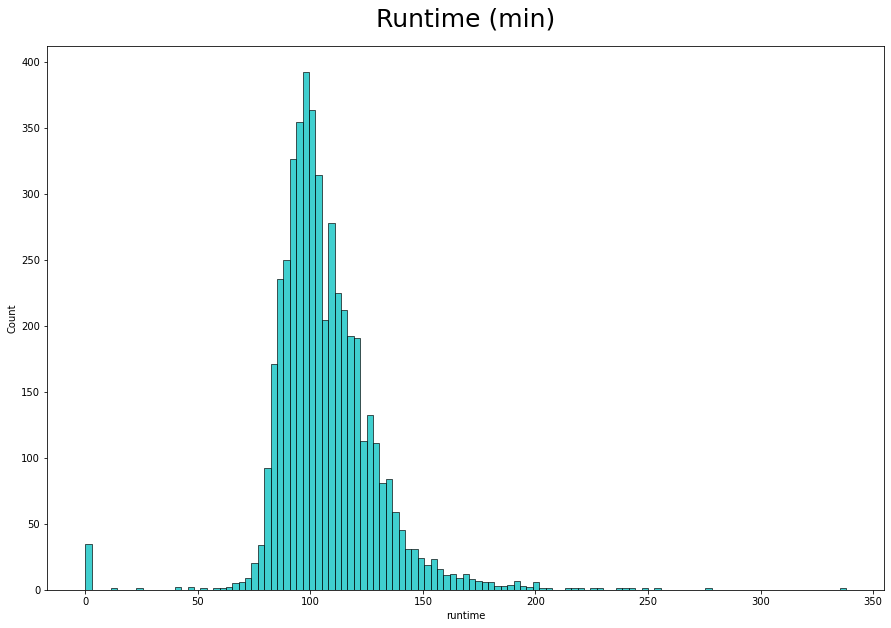

In [6]:
f, ax = plt.subplots(figsize=(15, 10))
plt.title("Runtime (min)", fontsize=25, pad=20)
sns.histplot(x="runtime", data=movie_df, color="c", label='Runtime')
plt.show()

##Budget

Text(0.5, 1.0, 'Budget (mmd)')

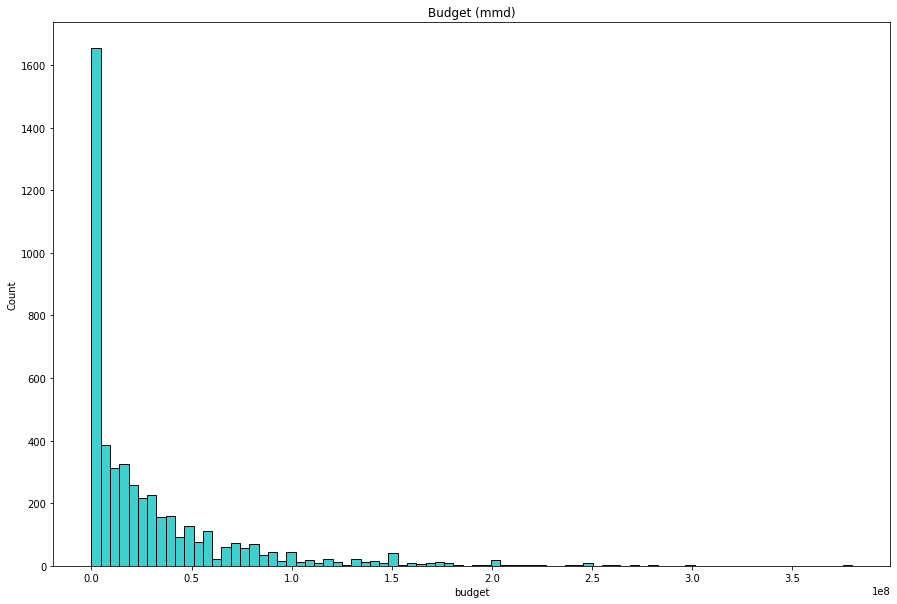

In [7]:
f, ax = plt.subplots(figsize=(15, 10))
sns.histplot(x="budget", data=movie_df, color="c", label='Budget (mm)').set_title('Budget (mmd)')

##Revenue

Text(0.5, 1.0, 'Revenue (mmd)')

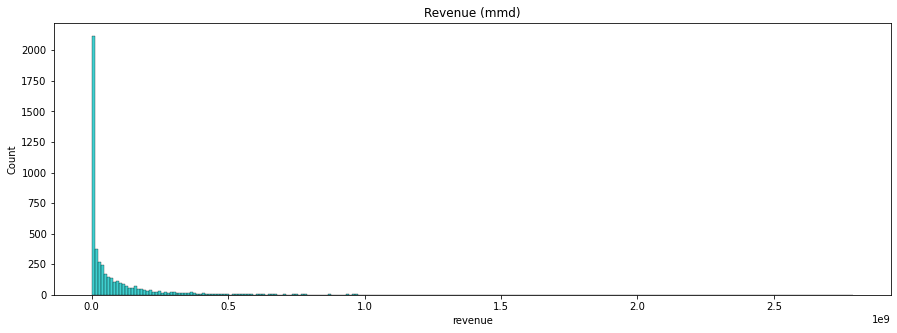

In [8]:
f, ax = plt.subplots(figsize=(15, 5))
sns.histplot(x="revenue", data=movie_df, color="c", label='Revenue (mm)').set_title('Revenue (mmd)')

##Normalizing data

In [9]:
movie_df['budget (mmd)'] = movie_df['budget']/1000000
movie_df['revenue (mmd)'] = movie_df['revenue']/1000000
del movie_df['budget']
del movie_df['revenue']

In [10]:
movie_df.head(1)

,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,...,status,tagline,title,vote_average,vote_count,tittle,cast,crew,budget (mmd),revenue (mmd)
0,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",...,Released,Enter the World of Pandora.,Avatar,7.2,11800,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de...",237.0,2787.965087


###Budget

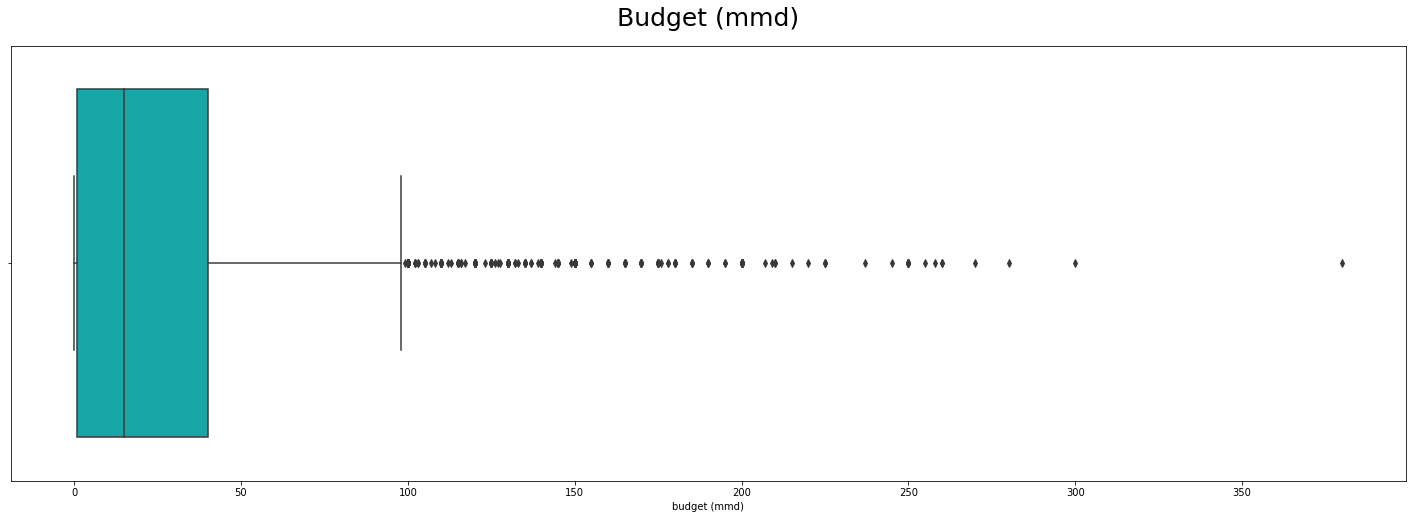

In [11]:
f, ax = plt.subplots(figsize=(25, 8))
plt.title("Budget (mmd)", fontsize=25, pad=20)
ax = sns.boxplot(x=movie_df["budget (mmd)"], color="c")
plt.show()


###Revenue

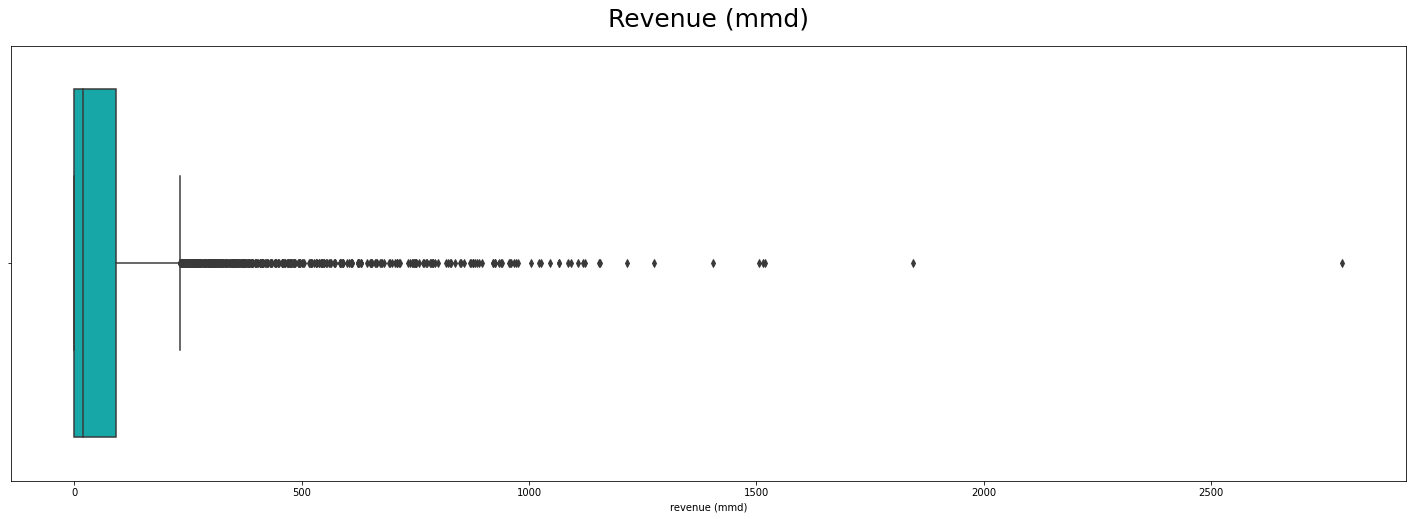

In [12]:
f, ax = plt.subplots(figsize=(25, 8))
plt.title("Revenue (mmd)", fontsize=25, pad=20)
ax = sns.boxplot(x=movie_df["revenue (mmd)"], color="c")
plt.show()

##Average score

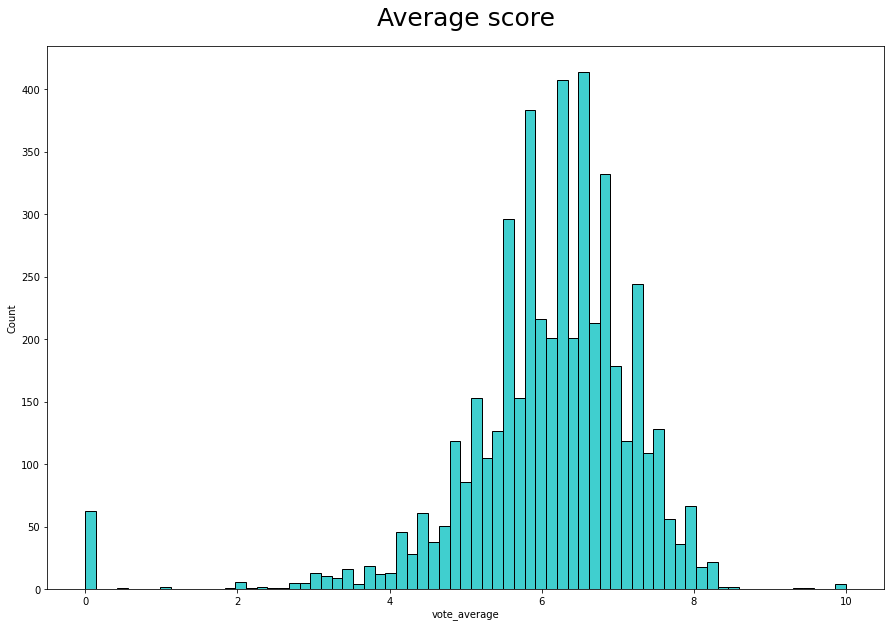

In [13]:
f, ax = plt.subplots(figsize=(15, 10))
plt.title("Average score", fontsize=25, pad=20)
sns.histplot(x="vote_average", data=movie_df, color="c", label='vote_average')
plt.show()

##Vote count

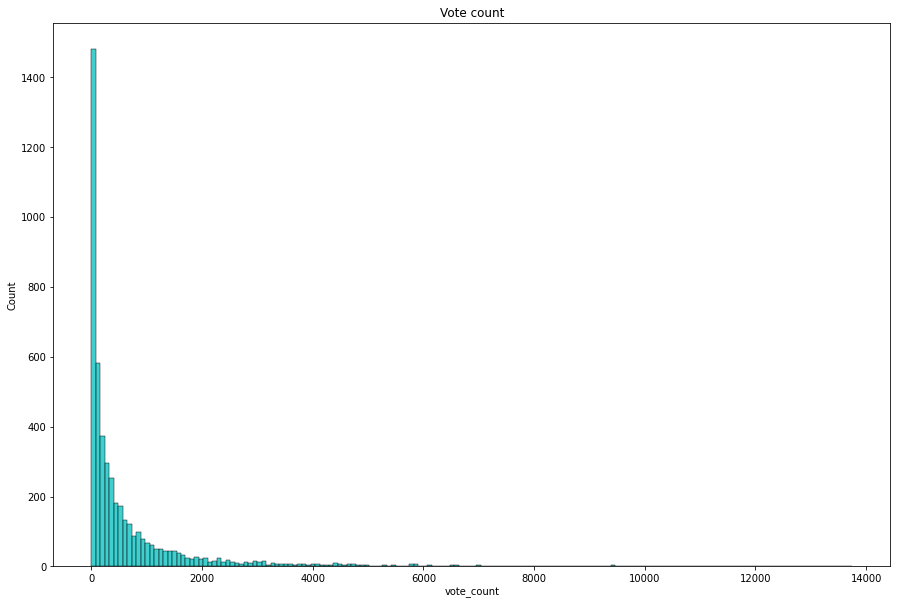

In [14]:
f, ax = plt.subplots(figsize=(15, 10))
plt.title("Vote count", fontsize=25, pad=20)
sns.histplot(x="vote_count", data=movie_df, color="c", label='vote_count').set_title('Vote count')
plt.show()

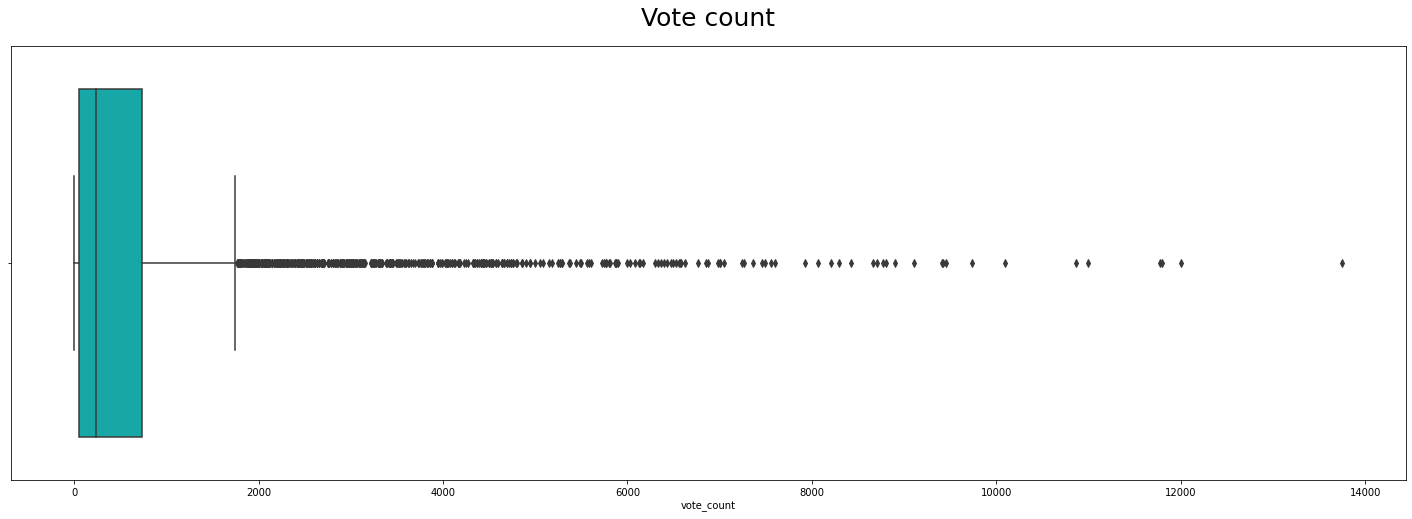

In [15]:
f, ax = plt.subplots(figsize=(25, 8))
plt.title("Vote count", fontsize=25, pad=20)
ax = sns.boxplot(x=movie_df["vote_count"], color="c")
plt.show()

##Year Released

In [16]:
movie_df['release_date'] = pd.to_datetime(movie_df['release_date'])
movie_df['release_year'] = movie_df['release_date'].dt.year
movie_df['release_month'] = movie_df['release_date'].dt.month_name()
del movie_df['release_date']

Text(0.5, 1.0, 'Year Released')

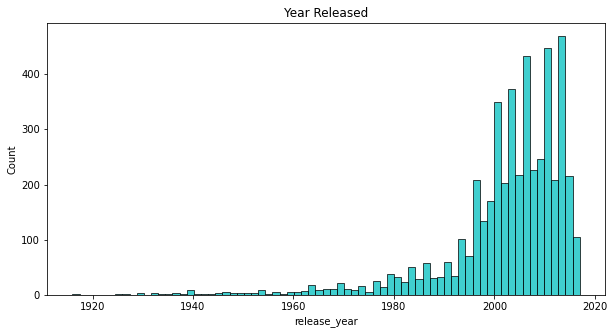

In [17]:
f, ax = plt.subplots(figsize=(10, 5))
sns.histplot(x="release_year", data=movie_df, color="c", label='release_year').set_title('Year Released')

##Original language

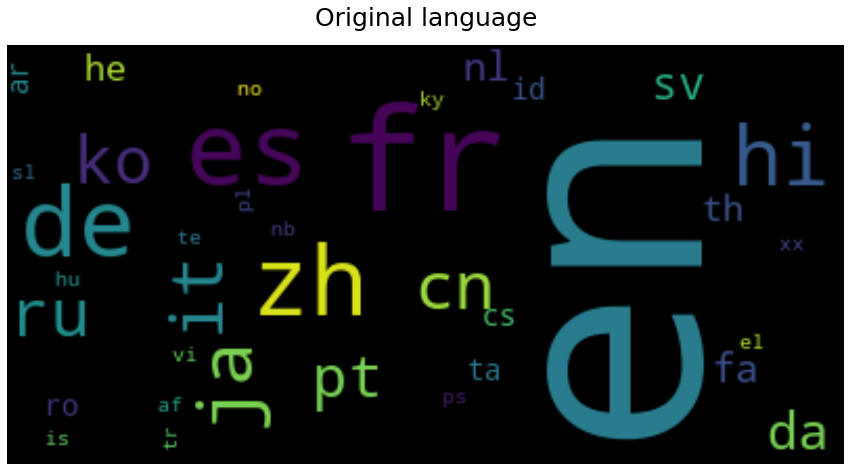

In [18]:
language = movie_df['original_language'].value_counts()
wordcloud = WordCloud().generate_from_frequencies(dict(language))

plt.figure(figsize=(15,10))
plt.title("Original language", fontsize=25, pad=20)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#Data Preparation

In [19]:
# transform all columns which had json string into json format leave only name for them
json_columns = {'cast', 'crew', 'genres', 'keywords', 'production_countries', 
                'production_companies', 'spoken_languages'}

for c in json_columns:
    movie_df[c] = movie_df[c].apply(json.loads)
    if c != "crew": 
        movie_df[c] = movie_df[c].apply(lambda row: [x["name"] for x in row])

In [20]:
# fill some missing values by most frequent one
for col in ["runtime", "release_year", "release_month"]:
    movie_df[col] = movie_df[col].fillna(movie_df[col].mode().iloc[0])

In [21]:
# create director writer and producer columns 
def get_job(job, row):
    person_name = [x['name'] for x in row if x['job']==job] 
    return person_name[0] if len(person_name) else np.nan

movie_df["director"] = movie_df["crew"].apply(partial(get_job, "Director"))
movie_df["writer"]   = movie_df["crew"].apply(partial(get_job, "Writer"))
movie_df["producer"] = movie_df["crew"].apply(partial(get_job, "Producer"))
del movie_df["crew"]

In [22]:
# fill missing values for the director, writer and producer columns

## ¿Será mejor hacer un drop a las películas que no contengan estos campos?

for col in ["director", "writer", "producer"]:
    movie_df[col] = movie_df[col].fillna(movie_df[col].mode().iloc[0])

In [23]:
movie_df.head(2)

,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,...,vote_count,tittle,cast,budget (mmd),revenue (mmd),release_year,release_month,director,writer,producer
0,"[Action, Adventure, Fantasy, Science Fiction]",http://www.avatarmovie.com/,19995,"[culture clash, future, space war, space colon...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[Ingenious Film Partners, Twentieth Century Fo...","[United States of America, United Kingdom]",...,11800,Avatar,"[Sam Worthington, Zoe Saldana, Sigourney Weave...",237.0,2787.965087,2009.0,December,James Cameron,James Cameron,James Cameron
1,"[Adventure, Fantasy, Action]",http://disney.go.com/disneypictures/pirates/,285,"[ocean, drug abuse, exotic island, east india ...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[Walt Disney Pictures, Jerry Bruckheimer Films...",[United States of America],...,4500,Pirates of the Caribbean: At World's End,"[Johnny Depp, Orlando Bloom, Keira Knightley, ...",300.0,961.000000,2007.0,May,Gore Verbinski,M. Night Shyamalan,Jerry Bruckheimer


##Top 10 production companies

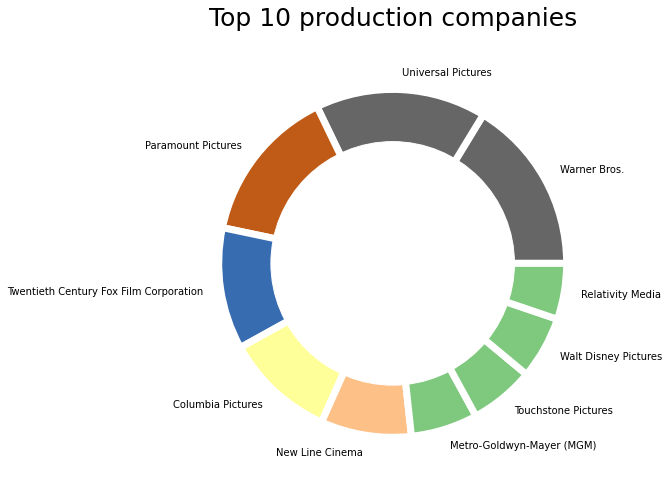

In [24]:
production_companies_flatten = sum(movie_df["production_companies"].values, [])
production_companies_info = Counter(production_companies_flatten)
top_production_companies = production_companies_info.most_common(10)

plt.figure(figsize=(16, 8))
my_circle = plt.Circle( (0,0), 0.7, color='white')
#Color palette
cmap = matplotlib.cm.Accent
mini=min(dict(top_production_companies).values())
maxi=max(dict(top_production_companies).values())
norm = matplotlib.colors.Normalize(vmin=mini, vmax=maxi)
colors = [cmap(norm(value)) for value in dict(top_production_companies).values()]

plt.title("Top 10 production companies", fontsize=25, pad=20)
plt.pie(dict(top_production_companies).values(), labels=dict(top_production_companies).keys(), colors=colors, wedgeprops = {'linewidth':7,'edgecolor':'white'})
p = plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

##Director with more movies

<BarContainer object of 10 artists>

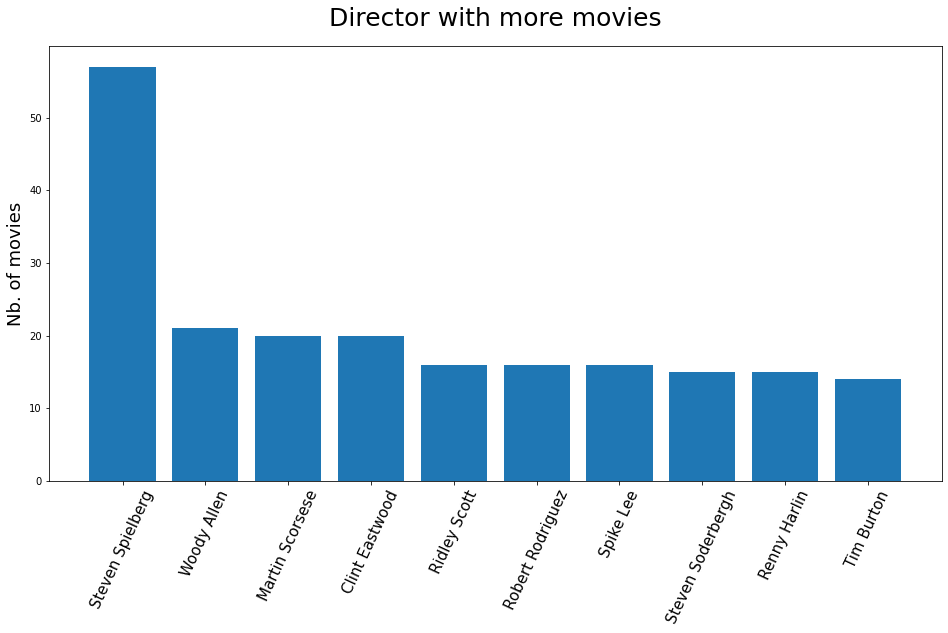

In [25]:
director_info = Counter(movie_df["director"])
top_director = director_info.most_common(10)

plt.figure(figsize=(16, 8))
plt.xticks(rotation=65, fontsize=15)
plt.ylabel("Nb. of movies", fontsize=18)
plt.title("Director with more movies", fontsize=25, pad=20)
plt.bar(dict(top_director).keys(), dict(top_director).values())

##Movie genres

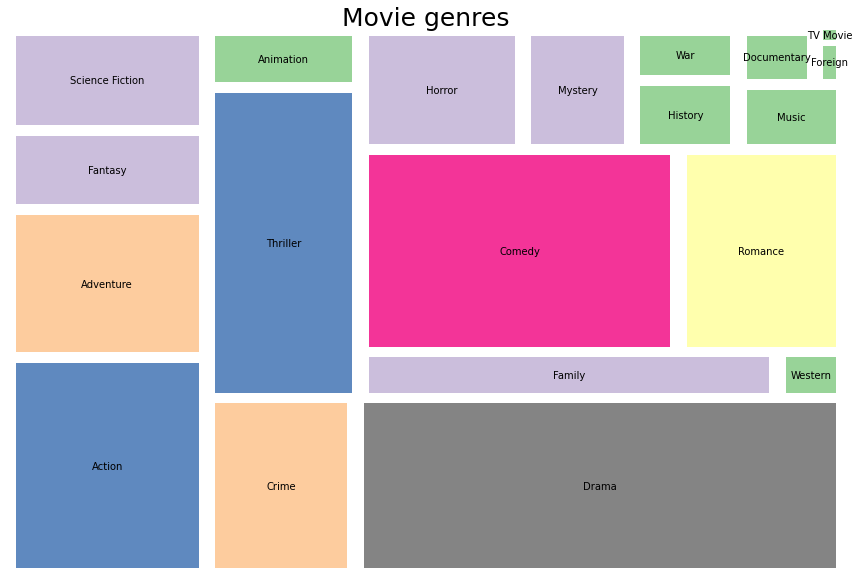

In [26]:
genres_flatten = sum(movie_df["genres"].values, []) 
genres_info = Counter(genres_flatten)

#create a color palette
cmap = matplotlib.cm.Accent
mini=min(genres_info.values())
maxi=max(genres_info.values())
norm = matplotlib.colors.Normalize(vmin=mini, vmax=maxi)
colors = [cmap(norm(value)) for value in genres_info.values()]

plt.figure(figsize=(15, 10))
plt.title("Movie genres", fontsize=25, pad=4)
squarify.plot(genres_info.values(), label=genres_info.keys(), color=colors, alpha=.8, pad=True)
plt.axis("off")
plt.show()

#Data Pre-processing

In [27]:
# to remove punctuations from overview
movie_df['overview'] = movie_df['overview'].str.replace('[^\w\s]','')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


In [28]:
df = movie_df[['genres','original_title','director','cast','overview','keywords']]
df.head(3)

,genres,original_title,director,cast,overview,keywords
0,"[Action, Adventure, Fantasy, Science Fiction]",Avatar,James Cameron,"[Sam Worthington, Zoe Saldana, Sigourney Weave...",In the 22nd century a paraplegic Marine is dis...,"[culture clash, future, space war, space colon..."
1,"[Adventure, Fantasy, Action]",Pirates of the Caribbean: At World's End,Gore Verbinski,"[Johnny Depp, Orlando Bloom, Keira Knightley, ...",Captain Barbossa long believed to be dead has ...,"[ocean, drug abuse, exotic island, east india ..."
2,"[Action, Adventure, Crime]",Spectre,Sam Mendes,"[Daniel Craig, Christoph Waltz, Léa Seydoux, R...",A cryptic message from Bonds past sends him on...,"[spy, based on novel, secret agent, sequel, mi..."


In [29]:
df['director'] = df['director'].map(lambda x: x.split(','))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [30]:
for index, row in df.iterrows():
    row['cast'] = [x.lower().replace(' ','') for x in row['cast']]
    row['director'] = [x.lower().replace(' ','') for x in row['director']]
    row['genres'] = [x.lower().replace(' ','') for x in row['genres']]

In [31]:
df.head(3)

,genres,original_title,director,cast,overview,keywords
0,"[action, adventure, fantasy, sciencefiction]",Avatar,[jamescameron],"[samworthington, zoesaldana, sigourneyweaver, ...",In the 22nd century a paraplegic Marine is dis...,"[culture clash, future, space war, space colon..."
1,"[adventure, fantasy, action]",Pirates of the Caribbean: At World's End,[goreverbinski],"[johnnydepp, orlandobloom, keiraknightley, ste...",Captain Barbossa long believed to be dead has ...,"[ocean, drug abuse, exotic island, east india ..."
2,"[action, adventure, crime]",Spectre,[sammendes],"[danielcraig, christophwaltz, léaseydoux, ralp...",A cryptic message from Bonds past sends him on...,"[spy, based on novel, secret agent, sequel, mi..."


In [32]:
df['Bag_of_words'] = ''
columns = ['genres', 'director', 'cast', 'keywords']

for index, row in df.iterrows():
    words = ''
    for col in columns:
        words += ' '.join(row[col]) + ' '
    row['Bag_of_words'] = words
    
df['Bag_of_words'] = df['Bag_of_words'].str.strip().str.replace('   ', ' ').str.replace('  ', ' ')

df = df[['original_title','Bag_of_words']]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [33]:
df

,original_title,Bag_of_words
0,Avatar,action adventure fantasy sciencefiction jamesc...
1,Pirates of the Caribbean: At World's End,adventure fantasy action goreverbinski johnnyd...
2,Spectre,action adventure crime sammendes danielcraig c...
3,The Dark Knight Rises,action crime drama thriller christophernolan c...
4,John Carter,action adventure sciencefiction andrewstanton ...
...,...,...
4798,El Mariachi,action crime thriller robertrodriguez carlosga...
4799,Newlyweds,comedy romance edwardburns edwardburns kerrybi...
4800,"Signed, Sealed, Delivered",comedy drama romance tvmovie scottsmith ericma...
4801,Shanghai Calling,danielhsia danielhenney elizacoupe billpaxton ...


#Recommender System

In [34]:
# to generate the count matrix
count = CountVectorizer()
count_matrix = count.fit_transform(df['Bag_of_words'])
count_matrix

<4803x64182 sparse matrix of type '<class 'numpy.int64'>'
	with 178724 stored elements in Compressed Sparse Row format>

In [35]:
cosine_sim = cosine_similarity(count_matrix, count_matrix)
print(cosine_sim)

[[1.         0.04055327 0.01659594 ... 0.03590948 0.         0.        ]
 [0.04055327 1.         0.03558591 ... 0.02566635 0.         0.        ]
 [0.01659594 0.03558591 1.         ... 0.         0.         0.        ]
 ...
 [0.03590948 0.02566635 0.         ... 1.         0.         0.        ]
 [0.         0.         0.         ... 0.         1.         0.        ]
 [0.         0.         0.         ... 0.         0.         1.        ]]


In [36]:
# Creating an index of the movies
indices = pd.Series(df['original_title'])
indices[:15]

0                                         Avatar
1       Pirates of the Caribbean: At World's End
2                                        Spectre
3                          The Dark Knight Rises
4                                    John Carter
5                                   Spider-Man 3
6                                        Tangled
7                        Avengers: Age of Ultron
8         Harry Potter and the Half-Blood Prince
9             Batman v Superman: Dawn of Justice
10                              Superman Returns
11                             Quantum of Solace
12    Pirates of the Caribbean: Dead Man's Chest
13                               The Lone Ranger
14                                  Man of Steel
Name: original_title, dtype: object

In [37]:
# this function takes in a movie title as input and returns the top 10 recommended (similar) movies

def recommend(title, cosine_sim = cosine_sim):
    recommended_movies = []
    idx = indices[indices == title].index[0]   # to get the index of the movie title matching the input movie
    score_series = pd.Series(cosine_sim[idx]).sort_values(ascending = False)   # similarity scores in descending order
    top_10_indices = list(score_series.iloc[1:11].index)   # to get the indices of the most similar movies
    
    for i in top_10_indices:   # to append the titles of the most similar movies to the recommended_movies list
        recommended_movies.append(list(df['original_title'])[i])
        
    return recommended_movies

In [38]:
recommend('Star Wars')

['The Empire Strikes Back',
 'Return of the Jedi',
 'Star Wars: Episode III - Revenge of the Sith',
 'Star Wars: Episode II - Attack of the Clones',
 'Star Wars: Clone Wars (Volume 1)',
 'Titan A.E.',
 'Star Wars: Episode I - The Phantom Menace',
 'Force 10 from Navarone',
 'Alien',
 'Gravity']

In [39]:
indices[1414]

'Blast from the Past'

In [40]:
recommend('Blast from the Past')

['Me You and Five Bucks',
 'The Cookout',
 'Smiling Fish & Goat On Fire',
 'Steppin: The Movie',
 'Dry Spell',
 'Griff the Invisible',
 'Beauty Shop',
 'The Puffy Chair',
 'And Then Came Love',
 "There's Something About Mary"]

In [41]:
recommend('Spider-Man')

['Spider-Man 2',
 'Spider-Man 3',
 'Highlander: Endgame',
 'Kung Pow: Enter the Fist',
 'The Count of Monte Cristo',
 'Cold Mountain',
 'X-Men',
 'Willard',
 'Thor',
 'The Amazing Spider-Man']

In [42]:
recommend('Indiana Jones and the Last Crusade')

['Raiders of the Lost Ark',
 'Indiana Jones and the Kingdom of the Crystal Skull',
 'Lara Croft Tomb Raider: The Cradle of Life',
 'The Adventures of Tintin',
 'Indiana Jones and the Temple of Doom',
 'Flywheel',
 'National Treasure',
 'Lara Croft: Tomb Raider',
 'How to Train Your Dragon 2',
 'Kingdom of Heaven']

In [43]:
recommend('Men of Honor')

['Last I Heard',
 'Straight Out of Brooklyn',
 'The Longest Ride',
 'Flawless',
 'August',
 'Dawn Patrol',
 'Radio',
 'End of the Spear',
 'Open Water',
 'Soul Food']

In [44]:
recommend('Hugo')

['This Christmas',
 'Miss Julie',
 'The Blue Butterfly',
 'Toy Story',
 'Eulogy',
 'End of the Spear',
 'A Shine of Rainbows',
 'Go for It!',
 'New York, New York',
 'Duma']